#### Tuesday, January 9, 2024

[Textual Inversion](https://huggingface.co/docs/diffusers/using-diffusers/textual_inversion_inference)

docker container start hfpt_Dec14

This all runs.

#### Textual Inversion

The StableDiffusionPipeline supports textual inversion, a technique that enables a model like Stable Diffusion to learn a new concept from just a few sample images. This gives you more control over the generated images and allows you to tailor the model towards specific concepts. You can get started quickly with a collection of community created concepts in the Stable Diffusion Conceptualizer.

This guide will show you how to run inference with textual inversion using a pre-learned concept from the Stable Diffusion Conceptualizer. If you’re interested in teaching a model new concepts with textual inversion, take a look at the Textual Inversion training guide.

Import the necessary libraries:

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers.utils import make_image_grid

##### Stable Diffusion 1 and 2

Pick a Stable Diffusion checkpoint and a pre-learned concept from the Stable Diffusion Conceptualizer:

In [2]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
repo_id_embeds = "sd-concepts-library/cat-toy"

Now you can load a pipeline, and pass the pre-learned concept to it:

In [3]:
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

pipeline.load_textual_inversion(repo_id_embeds)

# 14.8s

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Create a prompt with the pre-learned concept by using the special placeholder token <cat-toy>, and choose the number of samples and rows of images you’d like to generate:

In [4]:
prompt = "a grafitti in a favela wall with a <cat-toy> on it"

num_samples_per_row = 2
num_rows = 2

Then run the pipeline (feel free to adjust the parameters like num_inference_steps and guidance_scale to see how they affect image quality), save the generated images and visualize them with the helper function you created at the beginning:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

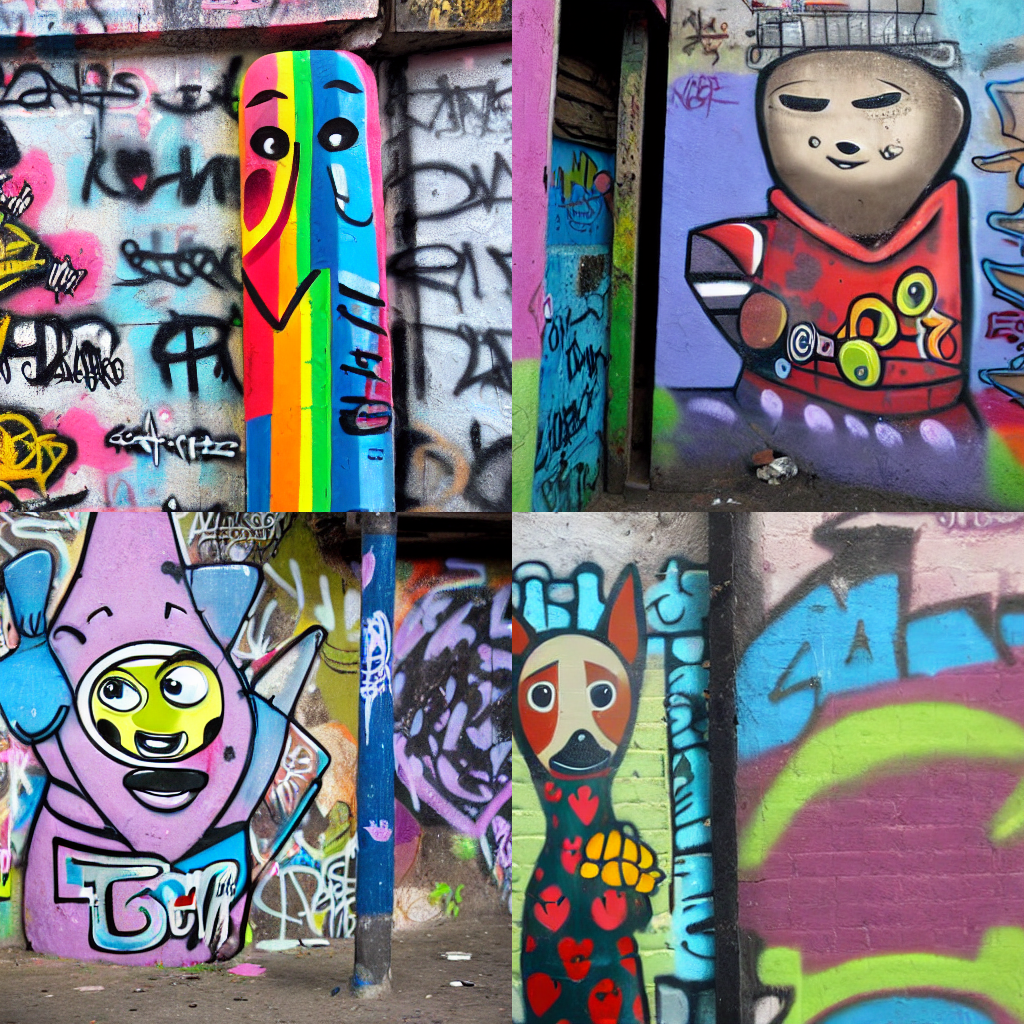

In [5]:
all_images = []
for _ in range(num_rows):
    images = pipeline(prompt, num_images_per_prompt=num_samples_per_row, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = make_image_grid(all_images, num_rows, num_samples_per_row)
grid

#### Stable Diffusion XL

Stable Diffusion XL (SDXL) can also use textual inversion vectors for inference. In contrast to Stable Diffusion 1 and 2, SDXL has two text encoders so you’ll need two textual inversion embeddings - one for each text encoder model.

Let’s download the SDXL textual inversion embeddings and have a closer look at it’s structure:

In [6]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

file = hf_hub_download("dn118/unaestheticXL", filename="unaestheticXLv31.safetensors")
state_dict = load_file(file)
state_dict

unaestheticXLv31.safetensors:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

{'clip_g': tensor([[ 0.0077, -0.0112,  0.0065,  ...,  0.0195,  0.0159,  0.0275],
         [ 0.0320, -0.0239,  0.0241,  ..., -0.0164,  0.0284, -0.0135],
         [-0.0303,  0.0069, -0.0071,  ...,  0.0100, -0.0251,  0.0164],
         ...,
         [ 0.0136, -0.0042,  0.0027,  ..., -0.0277, -0.0232, -0.0380],
         [ 0.0121, -0.0066,  0.0176,  ..., -0.0292,  0.0065, -0.0139],
         [-0.0170,  0.0213,  0.0143,  ..., -0.0302, -0.0240, -0.0362]],
        dtype=torch.float16),
 'clip_l': tensor([[ 0.0023,  0.0192,  0.0213,  ..., -0.0385,  0.0048, -0.0011],
         [-0.0079, -0.0240,  0.0062,  ..., -0.0042,  0.0103,  0.0328],
         [ 0.0096,  0.0127,  0.0181,  ..., -0.0076, -0.0272, -0.0204],
         ...,
         [ 0.0210,  0.0003,  0.0207,  ...,  0.0063, -0.0131,  0.0299],
         [ 0.0160, -0.0136,  0.0269,  ...,  0.0242,  0.0356, -0.0205],
         [ 0.0475, -0.0508, -0.0145,  ...,  0.0070, -0.0089, -0.0163]],
        dtype=torch.float16)}

There are two tensors, "clip_g" and "clip_l". "clip_g" corresponds to the bigger text encoder in SDXL and refers to pipe.text_encoder_2 and "clip_l" refers to pipe.text_encoder.

Now you can load each tensor separately by passing them along with the correct text encoder and tokenizer to load_textual_inversion():

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

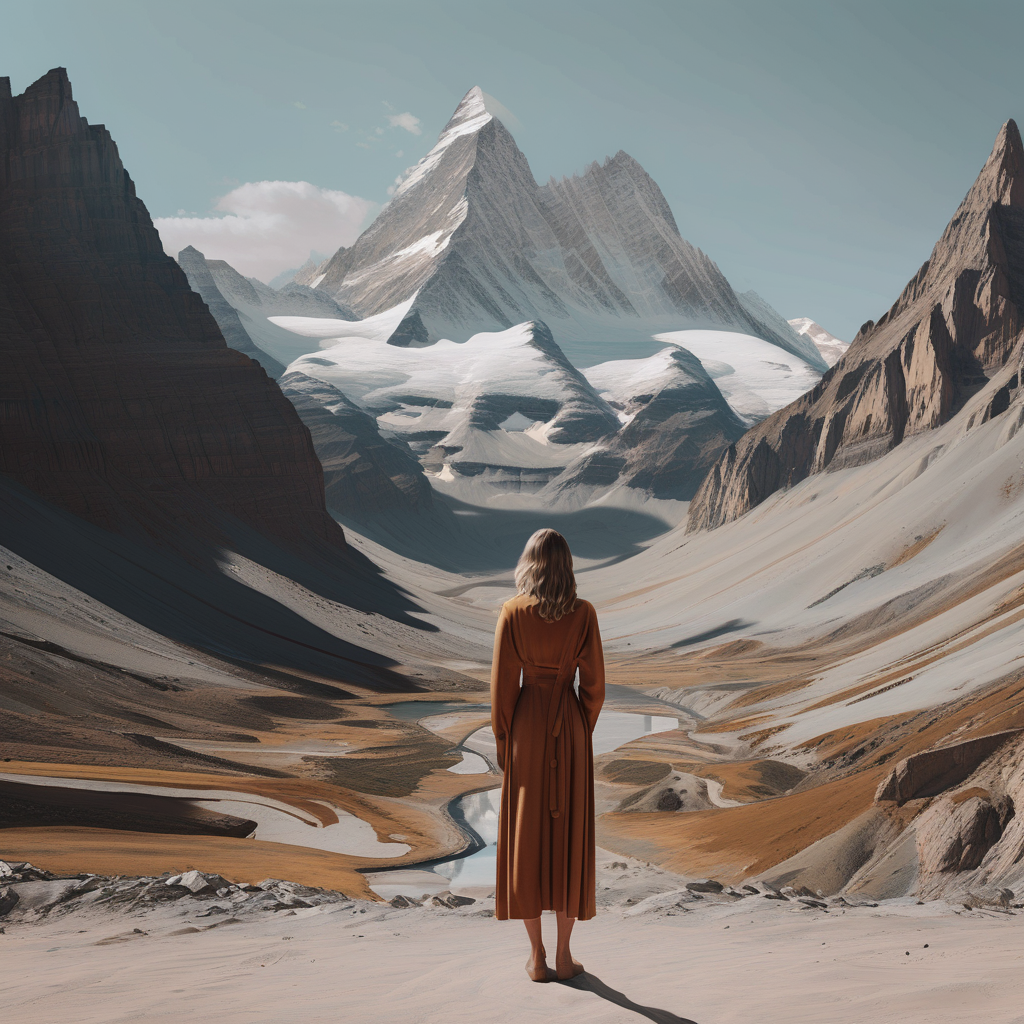

In [7]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", variant="fp16", torch_dtype=torch.float16)
pipe.to("cuda")

pipe.load_textual_inversion(state_dict["clip_g"], token="unaestheticXLv31", text_encoder=pipe.text_encoder_2, tokenizer=pipe.tokenizer_2)
pipe.load_textual_inversion(state_dict["clip_l"], token="unaestheticXLv31", text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer)

# the embedding should be used as a negative embedding, so we pass it as a negative prompt
generator = torch.Generator().manual_seed(33)
image = pipe("a woman standing in front of a mountain", negative_prompt="unaestheticXLv31", generator=generator).images[0]
image